<br>

## Spectogram model

<br>

<br>

### 음성데이터 추가

<br>

In [1]:
"""
데이터 준비
$ wget https://aiffelstaticdev.blob.core.windows.net/dataset/speech_wav_8000.npz
"""

"""
1000 Hz 신호를 저장한 wav 파일입니다.
Sample rate 는 48000 Hz, 즉 1초 재생하는데 필요한 Sample 수는 48000개입니다.
모든 샘플은 -1 ~ 1 사이의 정해진 bits per sample의 값으로 표현됩니다.
"""

import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

<br>

### 데이터셋 살펴보기

<br>

In [2]:
"""
npz 파일의 각 데이터는 "wav_vals", "label_vals"로 저장되어 있음
데이터셋 : 1초 길이의 오디오 음성데이터 50620개
1차원 wave binary 데이터의 경우, 원본 데이터의 sample rate은 16000, 여기서는 sr=8000 으로 resampling하여 사용
모든 데이터는 1초 길이의 음성데이터이므로 resampling 후 각각 8000개의 sample data 갖음
"""

print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [3]:
"""
샘플 데이터로 데이터 확인
"""

import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000       # sample rate : 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  44078
Wave data shape :  (8000,)
label :  ['unknown']


<br>

### 데이터 변환 Waveform to Spectogram <br>

__Spectogram 이란?__ <br>
wav 데이터를 해석하는 방법 중 하나로, 일정 시간동안 wav 데이터 안의 다양한 주파수들이 얼마나 포함되어 있는 지를 보여줍니다. 이 Spectrogram을 그리는 방법이 바로 위에 소개한 STFT 입니다. <br>
X축은 시간, Y축은 주파수를 나타내며, 해당 시간/주파수에서의 음파 강도에 따라 밝은색으로 표현됩니다.
wav 데이터가 단위 시간만큼 Short Time Fourier Transform을 진행해 매 순간의 주파수 데이터들을 얻어서 Spectrogram을 완성합니다. <br>
Step2에서 사용한 샘플데이터를 이용하여 스펙트로그램을 생성해 봅시다.

<br>

In [4]:
# librosa 라이브러리 설치 (FFT 관련 라이브러리)
# !pip install librosa

In [5]:
"""
1차원 Waveform 데이터를 2차원 Spectorgram 데이터로 변환하는 함수 정의
"""

import librosa

def wav2spec(wav, fft_size=258):            # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
    

# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)       # 1초 길이 음성 데이터 1개에 해당하는 1차원 wave binary 데이터 갯수
print("Spectrogram shape : ",spec.shape)    # 1초 길이 음성 데이터 1개에 해당하는 2차원 spectogram 데이터 갯수

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


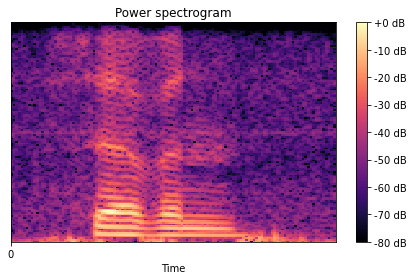

In [6]:
"""
변환된 Spectrogram을 출력
"""

import librosa.display
from matplotlib import pyplot as plt

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

In [7]:
"""
변환된 데이터 리스트에 저장
변환된 Spectrogram을 출력 ( 영준님 train feature dataset 생성 코드 참조 )
"""

spec = []
for v in speech_data["wav_vals"][:25000]:        # 전체 다 변환하면 컴퓨터 터지므로 25000개만 사용
    spec.append(wav2spec(v))
feature_data = np.array(spec)

print(len(feature_data))

25000


<br>

### Label data 처리

<br>

In [8]:
"""
단어의 정답은 Text 형태로 이뤄져있습니다.
학습을 위해서는 Text 데이터를 학습가능한 형태(index)로 만들어줘야 합니다.
"""

target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)


# Text 데이터를 index 데이터로 변환 (key:value 쌍으로)
new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [9]:
temp = []
for v in speech_data["label_vals"][:25000]:     # train feature dataset (feature_data) 개수에 맞추어 25000개만 사용
    temp.append(label_value[v[0]])
label_data = np.array(temp)

print(label_data)
print(len(label_data))

[3 3 3 ... 9 9 9]
25000


<br>

### Train / Test 데이터셋 분리

<br>

In [10]:
"""
sklearn으로 train셋과 test셋 분리 (모델 학습용)
"""

from sklearn.model_selection import train_test_split

x, y = (130, 126)       # 1차원 binary 데이터와 다르게 2차원 spectorgram 데이터의 크기 준비
train_spec, test_spec, train_label, test_label = train_test_split(feature_data, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_spec)
print("train data : ", train_spec.shape)
print("test data : ", test_spec.shape)

train_spec = train_spec.reshape([-1, x, y, 1]) # add channel for CNN
test_spec = test_spec.reshape([-1, x, y, 1])

[[[1.55061565e-03 1.63589267e-03 1.68156158e-03 ... 1.18746434e-03
   1.33793091e-03 1.84244011e-03]
  [1.05506973e-03 5.46482857e-04 1.15300680e-03 ... 5.02096489e-04
   8.85896967e-04 1.07546430e-03]
  [8.68082047e-04 7.76800909e-04 3.11928743e-04 ... 9.55605414e-04
   5.95316698e-04 4.76372952e-05]
  ...
  [4.53151961e-06 2.48095739e-06 9.98187170e-06 ... 6.37358698e-06
   1.71422962e-05 3.15683028e-05]
  [7.79967104e-06 7.32236640e-06 1.99922511e-06 ... 3.61622801e-06
   8.33881404e-06 1.86168181e-05]
  [1.31020688e-05 6.50461698e-06 1.83604030e-07 ... 2.19616112e-07
   1.07153037e-05 1.97775207e-05]]

 [[1.02576725e-02 4.32301499e-03 1.11044226e-02 ... 1.46740451e-02
   1.16678327e-02 1.41732916e-02]
  [1.81922745e-02 1.80872194e-02 1.07648112e-02 ... 1.00367283e-02
   4.15292569e-03 1.06220953e-02]
  [1.59839652e-02 1.57163963e-02 1.48313893e-02 ... 6.49623061e-03
   4.89238137e-03 5.18208882e-03]
  ...
  [1.34009475e-04 8.08598488e-05 4.96506691e-05 ... 5.30394645e-05
   7.61095

In [11]:
print("train data : ", train_spec.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_spec.shape)
print("test labels : ", test_label.shape)

train data :  (22500, 130, 126, 1)
train labels :  (22500,)
test data :  (2500, 130, 126, 1)
test labels :  (2500,)


In [12]:
"""
학습을 위한 하이퍼파라미터 설정
모델 체크포인트 저장을 위한 경로 설정
( 이후에 모델 체크포인트 Callback 함수를 설정하거나 모델을 불러올 때 사용 )
"""

batch_size = 32                     # batch_size=32, max_epochs=10으로 세팅한 경우라면 30분 가량 소요
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec'

checkpoint_dir

'/home/ssac29/aiffel/speech_recognition/models/spec'

<br>

### 데이터 전처리

<br>

In [13]:
"""
데이터 전처리 함수 작성 ( map 함수에 넘겨주기 위해 )
"""

def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [14]:
"""
tf.data.Dataset 함수를 구성
"""


import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
                                            # batch()는 dataset에서 제공하는 튜플 형태의 데이터를 얼마나 가져올지 결정하는 함수
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


<br>

### Model construction &ensp; : Skip-Connection 모델 구현

<br>

In [15]:
"""
Model
Audio 데이터는 1차원 데이터이기 때문에 데이터 형식에 맞도록 모델을 구성
Conv1D layer를 이용해서 모델을 구성
Conv, batch norm, dropout, dense layer 등을 이용해 모델을 구성
"""

from tensorflow.keras import layers

input_tensor = layers.Input(shape=(x, y))       # input data로 1차원 binary 데이터의 (sp, 1) 대신, 
                                                # input data로 2차원 spectogram 데이터의 (x, y)

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec = tf.keras.Model(input_tensor, output_tensor)

model_spec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0     

In [16]:
"""
Loss
라벨이 될 수 있는 12개의 단어 class를 구분하기 위해서는 multi-class classification이 필요
이를 위한 Loss로 Categorical Cross-Entropy loss를 사용
"""

optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

<br>

### 모델 학습

<br>

__Callback__ <br>

- model.fit 함수를 이용할 때, callback 함수를 이용해서 학습 중간 중간 원하는 동작을 하도록 설정할 수 있습니다. <br>
- 모델을 재사용하기위해서 모델 가중치를 저장하는 callback 함수를 추가해보겠습니다.

In [17]:
"""
Model Checkpoint callback은 
모델을 학습을 진행하며, fit 함수내 다양한 인자를 지정해 모니터하며 동작하게 설정할 수 있습니다.
현재 모델은 validation loss를 모니터하며, loss가 낮아지면 모델 파라미터를 저장하도록 구성되어 있습니다.
"""

# 하이퍼파라미터 세팅의 checkpoint_dir 사용

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [18]:
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_spec = model_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
701/703 [============================>.] - ETA: 0s - loss: 1.5132 - accuracy: 0.4792
Epoch 00001: val_loss improved from inf to 1.06247, saving model to /home/ssac29/aiffel/speech_recognition/models/spec
703/703 [==============================] - 6s 8ms/step - loss: 1.5127 - accuracy: 0.4793 - val_loss: 1.0625 - val_accuracy: 0.6258
Epoch 2/10
700/703 [============================>.] - ETA: 0s - loss: 0.8206 - accuracy: 0.7203
Epoch 00002: val_loss improved from 1.06247 to 0.67157, saving model to /home/ssac29/aiffel/speech_recognition/models/spec
703/703 [==============================] - 5s 8ms/step - loss: 0.8203 - accuracy: 0.7203 - val_loss: 0.6716 - val_accuracy: 0.7684
Epoch 3/10
701/703 [============================>.] - ETA: 0s - loss: 0.5419 - accuracy: 0.8179
Epoch 00003: val_loss improved from 0.67157 to 0.53303, saving model to /home/ssac29/aiffel/speech_recognition/models/spec
703/703 [==============================] - 5s 8ms/step - loss: 0.5420 - accuracy: 0.8

<br>

### 학습결과 plot

<br>

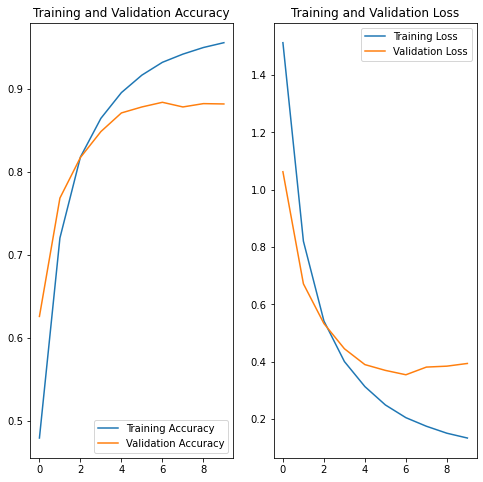

In [19]:
"""
model.fit 함수는 학습 동안의 결과를 return해줍니다.
return 값을 기반으로 loss와 accuracy를 그래프로 표현하겠습니다.
fit 함수에서 전달 받은 Loss와 Accuracy의 값을 이용해 모델이 어떻게 학습되고 있는지 볼 수 있습니다.
train loss와 val_loss의 차이가 커지는 경우 오버피팅이 일어나는 것이기 때문에 이를 수정할 필요가 있습니다.

출력된 그래프를 기반으로 모델의 학습이 어떻게 진행됐는지 확인
"""

import matplotlib.pyplot as plt

acc = history_spec.history['accuracy']
val_acc = history_spec.history['val_accuracy']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<br>

### 모델 평가 Evaluation

<br>

In [20]:
"""
Test dataset을 이용해서 모델의 성능을 평가합니다.
"""

# 실습삼아 checkpoint callback 함수가 저장한 weight를 다시 불러와서 테스트
model_spec.load_weights(checkpoint_dir)

# Test data을 이용하여 모델의 예측값과 실제값이 얼마나 일치하는지 확인
results = model_spec.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

79/79 [==============================] - 13s 167ms/step - loss: 0.3537 - accuracy: 0.8840
loss value: 0.354
accuracy value: 88.4000%
